```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from matplotlib import animation, rc, colors, colorbar
from matplotlib import pyplot as plt

from IPython.display import display
from IPython.display import Video

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities, NetCDFInitialization

from demos.realisticSimulations import norkyst_plotting

In [3]:
%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 0, 0)
Driver version 10020
Using 'GeForce GTX 780' GPU
Created context handle <94755259164192>


In [4]:
#Set this to false before comitting to only get images
create_movie = False
movie_frames = 200 
download_data = False

In [5]:
#case = 1 # Open waters in the Norwegian Sea
case = 2 # Lofoten
#case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'

if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = casename+datetime.datetime.now().strftime("%Y_%m_%d")

# Overrule the above folder name:
#folder = 'norwegian_sea_2019_10_09'
#folder = 'lofoten_2019_10_07'
#folder = 'complete_coast_2019_10_09'

assert(folder.startswith(casename)), 'folder does not start with casename!'

os.makedirs(folder, exist_ok=True)
print(folder)

lofoten_2020_04_28


In [6]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

In [7]:
if (download_data):
    
    filename = os.path.abspath(os.path.basename(source_url))
    cache_folder='netcdf_cache'
    cache_filename = os.path.abspath(os.path.join(cache_folder,
                                                  os.path.basename(source_url)))
    
    if (os.path.isfile(filename)):
        source_url = filename
        
    elif (os.path.isfile(cache_filename)):
        source_url = cache_filename
    
    else:
        import requests
        download_url = source_url.replace("dodsC", "fileServer")

        req = requests.get(download_url, stream = True)
        filesize = int(req.headers.get('content-length'))

        progress = Common.ProgressPrinter()
        pp = display(progress.getPrintString(0),display_id=True)

        print("Downloading data to local file (" + str(filesize // (1024*1024)) + " MB)")
        with open(filename, "wb") as outfile:
            for chunk in req.iter_content(chunk_size = 10*1024*1024):
                if chunk:
                    outfile.write(chunk)
                    pp.update(progress.getPrintString(outfile.tell() / filesize))

        source_url = filename
        
print("Source is : " + source_url)

Source is : https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


In [8]:
##### 
case2_x0 = 1650
case2_x1 = int(case2_x0 + 100)
case2_y0 = 525
case2_y1 = int(case2_y0 + 50)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875

## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:
    print('using Norwegian Sea area')


using the Lofoten case


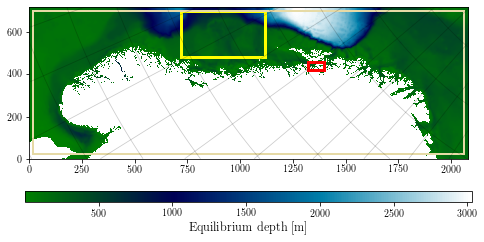

In [9]:
def plotMapAndCases():
    try:
        ncfile = Dataset(source_url)
        H_full = np.array(ncfile.variables['h'])
        angle = np.array(ncfile.variables['angle'])
        lat = np.array(ncfile.variables["lat"])
        lon = np.array(ncfile.variables["lon"])
    except Exception as e:
        raise e

    finally:
        ncfile.close()

        land_value = H_full.min()
    (full_ny, full_nx) = H_full.shape

    # Makes sure axis are in km (assuming equidistant 800x800m grid)
    extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


    fig = plt.figure(figsize=(8,4))

    # Land and bathymetry
    land = np.ma.masked_where(H_full == land_value, H_full)
    im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
               extent=extent)

    cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
    cbar.set_label('Equilibrium depth [m]', size=12.5)


    # Case boxes
    fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
                   np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
                   fill=False, linestyle='-', linewidth=3, color='yellow')
    fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
                   np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
                   fill=False, linestyle='-', linewidth=3, color='red')

    # Save without north arrow
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway.png'))

    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN.png'))

    fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
                   np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
                   fill=False, linestyle='-', linewidth=2, color='xkcd:beige')

    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases.png'))

    plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.png'))

plotMapAndCases()

In [10]:
def checkXandY():
    try:
        ncfile = Dataset(source_url)
        x = ncfile.variables['X']
        y = ncfile.variables['Y']
        print("read x and y with shapes:", x.shape, y.shape)
        
        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        print("got dx and dy with shapes:", dx.shape, dy.shape)
        
        print("min and max dx: ", np.min(dx), np.max(dx))
        print("min and max dy: ", np.min(dy), np.max(dy))
        
        print(x[0], x[-1])
    except Exception as e:
        raise e
    finally:
        ncfile.close()

checkXandY()

read x and y with shapes: (2602,) (902,)
got dx and dy with shapes: (2601,) (901,)
min and max dx:  800.0 800.0
min and max dy:  800.0 800.0
0.0 2080800.0


In [11]:
def runMidpointsToIntersections():

    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
        eta = ncfile.variables['zeta'][0, y0-1:y1+1, x0-1:x1+1]
        print("Read Hm as " + str(H_m.shape))

    except Exception as e:
        raise e
    finally:
        ncfile.close()

    #Apply land mask
    land_value = 5.0
    from scipy.ndimage.morphology import binary_erosion
    H_m = np.ma.array(H_m, mask =eta.mask)

    importlib.reload(OceanographicUtilities)
    H_i, convergence = OceanographicUtilities.midpointsToIntersections(H_m, iterations=21, tolerance=0, land_value=5.0, compute_convergence=True)
    H_m_new = OceanographicUtilities.intersectionsToMidpoints(H_i)
    
    return H_i, H_m_new, H_m[1:-1,1:-1], convergence
H_i, H_m, H_m_new, convergence = runMidpointsToIntersections()

Read Hm as (52, 102)


In [12]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

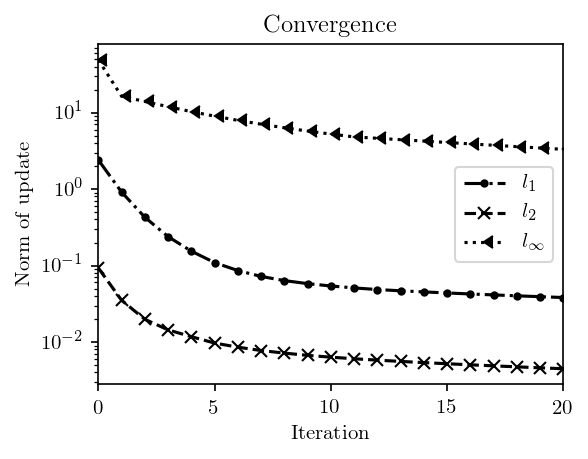

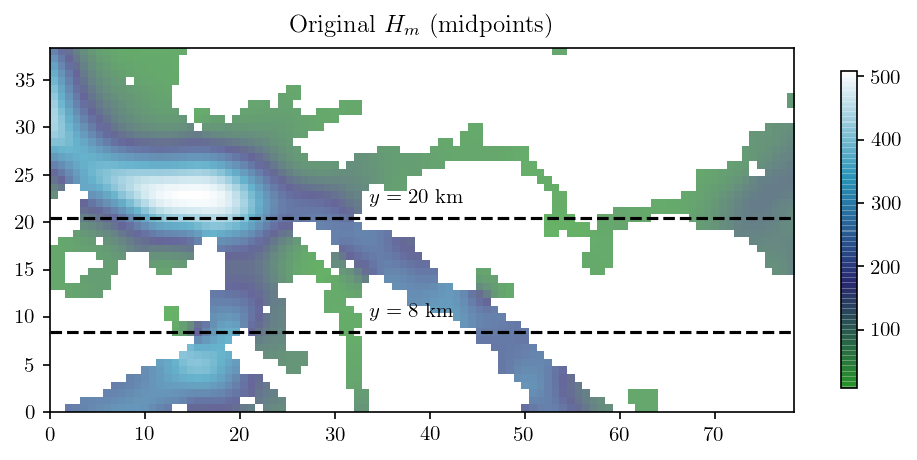

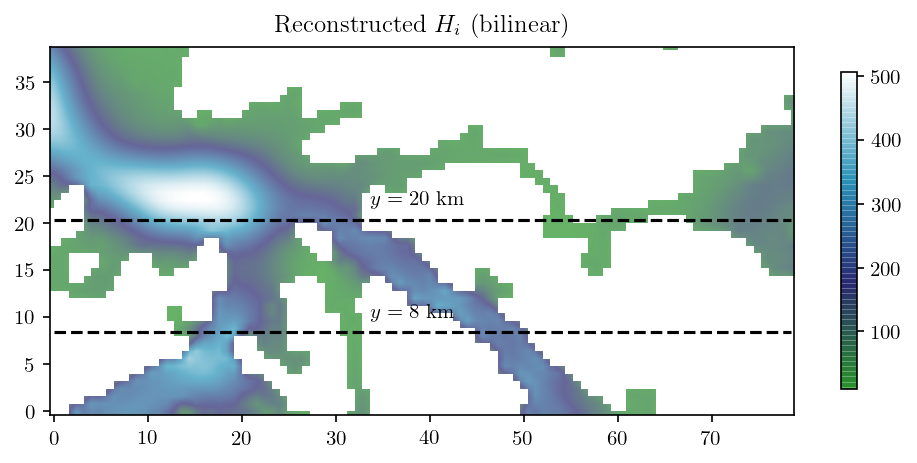

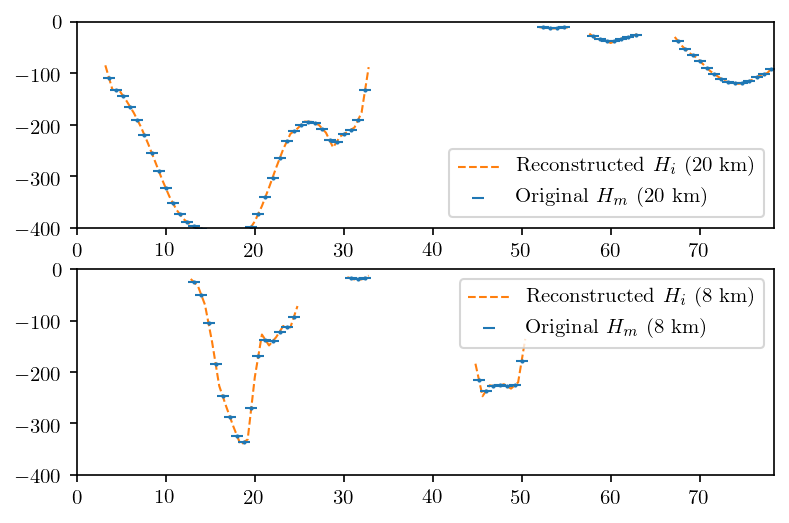

In [13]:
def plotMidpointsToIntersections(H_i, H_m, H_m_new, convergence):

    nx = x1-x0-2
    ny = y1-y0-2
    dx = 0.8#800.0/1000
    dy = 0.8#800.0/1000
    
    #lines = [85, 115]
    lines = [25, 10]
    
    tex_labels = {'l_1': 'l_1', 'l_2': 'l_2', 'l_inf': 'l_{\infty}'}
        
    fig = plt.figure(figsize=(4,3), dpi=150)
    setBwStyles(fig.gca())
    for l in ['l_1', 'l_2', 'l_inf']:
        plt.semilogy(np.linspace(0, len(convergence[l])-1, len(convergence[l])), convergence[l], label="$" + tex_labels[l] + "$")
    plt.xlim([0, 20])
    plt.xticks([0, 5, 10, 15, 20])
    plt.ylabel('Norm of update')
    plt.xlabel('Iteration')
    plt.title("Convergence")
    plt.legend()
    plt.savefig("bathymetry_convergence.pdf", bbox_inches = "tight")

    fig = plt.figure(figsize=(8,4), dpi=150)
    plt.imshow(H_m_new, interpolation="None", origin='lower', cmap='ocean', extent=[0, nx*dx, 0, ny*dy], alpha=0.6)
    plt.colorbar(shrink=0.7)
    plt.title("Original $H_m$ (midpoints)")
    plt.savefig("original_Hm_noline.pdf", bbox_inches = "tight")
    for line in lines:
        plt.annotate("$y = {:.0f}$ km".format((line+0.5)*dy), (42*dx, (line+2.5)*dy))
        plt.plot([0, nx*dx], [(line+0.5)*dy, (line+0.5)*dy], 'k--')
    #plt.colorbar(shrink=0.7)
    #plt.title("Original $H_m$ (midpoints)")
    plt.savefig("original_Hm.pdf", bbox_inches = "tight")

    fig = plt.figure(figsize=(8, 4), dpi=150)
    plt.imshow(H_i, interpolation="bilinear", origin='lower', cmap='ocean', extent=[-0.5*dx, (nx+0.5)*dx, -0.5*dy, (ny+0.5)*dy], alpha=0.6)
    plt.colorbar(shrink=0.7)
    plt.title("Reconstructed $H_i$ (bilinear)")
    plt.savefig("reconstructed_Hi_noline.pdf", bbox_inches = "tight")
    for line in lines:
        plt.annotate("$y = {:.0f}$ km".format((line+0.5)*dy), (42*dx, (line+2.5)*dy))
        plt.plot([0, nx*dx], [(line+0.5)*dy, (line+0.5)*dy], 'k--')
    #plt.colorbar(shrink=0.7)
    #plt.title("Reconstructed $H_i$ (bilinear)")
    plt.savefig("reconstructed_Hi.pdf", bbox_inches = "tight")
    
    #fig = plt.figure(figsize=(16,8))
    #plt.imshow(H_m-H_m_new, interpolation="None", origin='lower', cmap='ocean')
    #plt.colorbar(shrink=0.6)
    #plt.title("Hm diff")
    
    fig = plt.figure(figsize=(6,4), dpi=150)
    for i, j in enumerate(lines):
        plt.subplot(2,1,i+1)
        #plt.title("$y = {:.0f}$ km".format((j+0.5)*dy))
        plt.plot(np.linspace(0, nx*dx, nx+1), -0.5*(H_i[j,:]+H_i[j+1,:]), '--', color='tab:orange', linewidth=1, label="Reconstructed $H_i$ ({:.0f} km)".format((j+0.5)*dy))
        plt.plot(np.linspace(0.5*dx, (nx-0.5)*dx, nx), -H_m[j,:], '_', color='tab:blue', label="Original $H_m$ ({:.0f} km)".format((j+0.5)*dy))
        plt.plot(np.linspace(0.5*dx, (nx-0.5)*dx, nx), -H_m[j,:], '.', color='tab:blue', markersize=2)
        #plt.plot(H_m_new[i,:], 'x', label='$R_' + str(i) + "$")
        #plt.legend(loc='lower right')
        plt.legend()
        plt.xlim([0, nx*dx])
        plt.ylim([-400, 0])
    plt.savefig("bathymetry_reconstruction.pdf", bbox_inches = "tight")
    
plotMidpointsToIntersections(H_i[1:-1, 1:-1], H_m[1:-1, 1:-1], H_m_new[1:-1, 1:-1], convergence)

In [14]:
ic = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1)

Range eta0 [0.62100005, 0.21400002]
Range hu0 [23.73975344622078, -64.08888087418283]
Range hv0 [51.271153630698365, -15.624124436160455]
Range H [505.45035196372055, 7.5085129737854]
Range angle [0.9551278352737427, 0.9206206202507019]
t0 2019-07-16 00:00:00
Timesteps [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


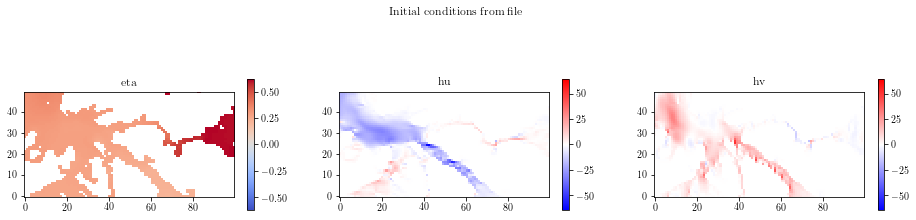

In [15]:
def plotInitialConditions():
    etamax = np.max(np.abs(ic['eta0']))
    uvmax = max(np.max(np.abs(ic['hu0'])), np.max(np.abs(ic['hv0'])))
    
    plt.figure(figsize=(16, 4))
    plt.suptitle("Initial conditions from file")

    plt.subplot(1,3,1)
    plt.title("eta")
    plt.imshow(ic['eta0'], interpolation="None", origin='lower', cmap='coolwarm', vmin=-etamax, vmax=etamax)
    plt.colorbar(shrink=0.6)

    plt.subplot(1,3,2)
    plt.title("hu")
    plt.imshow(ic['hu0'], interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
    plt.colorbar(shrink=0.6)

    plt.subplot(1,3,3)
    plt.title("hv")
    plt.imshow(ic['hv0'], interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
    plt.colorbar(shrink=0.6)

    for var in ['eta0', 'hu0', 'hv0', 'H', 'angle']:
        print("Range", var, [np.max(ic[var]), np.min(ic[var])])
    
    print("t0", datetime.datetime.utcfromtimestamp(ic['t0']))
    print("Timesteps", ic['boundary_conditions_data'].t/3600)

plotInitialConditions()

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

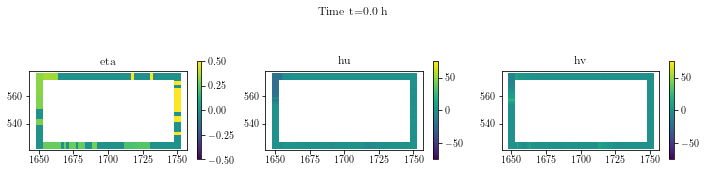

In [16]:
importlib.reload(norkyst_plotting)
norkyst_plotting.bcAnimation(ic['boundary_conditions_data'], x0, x1, y0, y1, create_movie=create_movie)

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

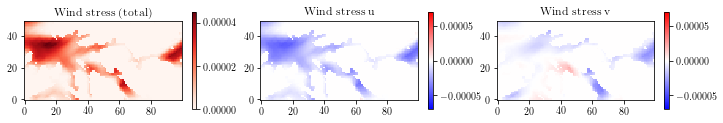

In [17]:
   
norkyst_plotting.animateWind(ic['wind_stress'], create_movie=create_movie)

(-0.05, 1.05, -0.05500000000000001, 0.05500000000000001)

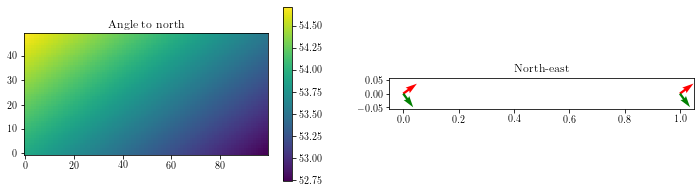

In [18]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Angle to north")
plt.imshow(ic['angle']*180/np.pi, origin='lower')
plt.axis('image')
plt.colorbar(shrink=0.4)

plt.subplot(1,2,2)
plt.title("North-east")
plt.quiver(np.sin(ic['angle'][::50, ::50]), np.cos(ic['angle'][::50, ::50]), color='r')
plt.quiver(np.cos(ic['angle'][::50, ::50]), -np.sin(ic['angle'][::50, ::50]), color='g')
plt.axis('image')

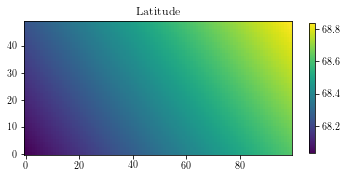

In [19]:
try:
    ncfile = Dataset(source_url)
    lat = ncfile.variables["lat"][y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()
    
plt.figure()
plt.title("Latitude")
plt.imshow(lat, origin='lower')
plt.colorbar(shrink=0.6)

In [20]:
max_lat = np.max(lat)
min_lat = np.min(lat)
max_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(max_lat))
min_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(min_lat))
print("Max latitude: " + str(max_lat) + " => " + str(max_cor))
print("Min latitude: " + str(min_lat) + " => " + str(min_cor))

f, beta = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat[0, 0]))
print("F and beta are " + str([f, beta]))

Max latitude: 68.83847584994807 => [0.00013600735369581, 8.263797936314033e-12]
Min latitude: 68.03135126068845 => [0.0001352522219116731, 8.563694856185286e-12]
F and beta are [0.0001352522219116731, 8.563694856185286e-12]


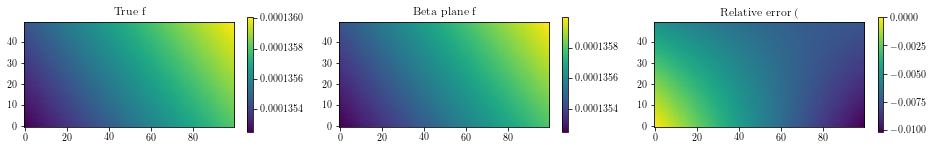

In [21]:
f_truth, _ = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat))

#Calculate beta plane approximation
YY, XX = np.mgrid[0:(y1-y0), 0:(x1-x0)]
XX = XX*ic['dx']
YY = YY*ic['dy']
local_lat = np.sin(ic['angle'])*XX + np.cos(ic['angle'])*YY
f_beta = f + beta*local_lat

plt.figure(figsize=(16, 3))
plt.subplot(1,3,1)
plt.title("True f")
plt.imshow(f_truth, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)


plt.subplot(1,3,2)
plt.title("Beta plane f")
plt.imshow(f_beta, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Relative error (%)")
plt.imshow(100*(f_beta-f_truth) / f_truth, origin='lower')#, vmin=-0.0001, vmax=0.0)
plt.colorbar(shrink=0.7)



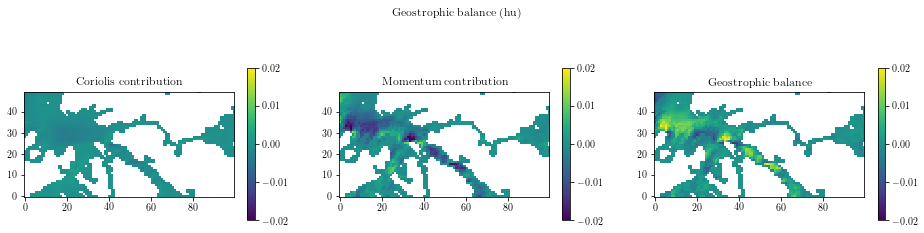

In [22]:
geos, geos_x, geos_y = OceanographicUtilities.calcGeostrophicBalance(
                            ic['eta0'], 
                            OceanographicUtilities.intersectionsToMidpoints(ic['H']), 
                            ic['hu0'], ic['hv0'], 
                            ic['angle'], f_beta,
                            ic['dx'], ic['dy'],
                            use_minmod=True)

plt.figure(figsize=(16,4))
plt.suptitle("Geostrophic balance (hu)")
plt.subplot(1,3,1)
plt.title("Coriolis contribution")
plt.imshow(geos_x[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.title("Momentum contribution")
plt.imshow(geos_x[1], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Geostrophic balance")
plt.imshow(geos[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)